# An Introduction to Agent-Based Models: Simulating Segregation with Python

In this project, we will explore an approach that has become popular in economics: agent-based models. These are models in which agents are assumed to follow very simple behavioural rules. Their interaction, however, yields complex dynamics and sometimes surprising results. 

One of the pioneers of these models is Schelling. He used this approach to study the phenomenon of racial segregation in urban areas, i.e. the fact that neighboroods in large cities tend to become racially homogenous, creating a racial segregation in the urban space. 




## Motivation

Many US cities are extremely racially segregated. People from the same race tend to live in the same neighborood. The map below is from Chicago. 

<img src="silver-segregation-hydepark-dot.png" alt="alt text" width="400"/>

Source: https://fivethirtyeight.com/features/the-most-diverse-cities-are-often-the-most-segregated/



Source: http://demographics.coopercenter.org/DotMap/index.html -->

This is a phenomenon that is common to most US cities, and also some European ones. Here is a map of London, showing a similar segregation:

<img src="http://blogs.lshtm.ac.uk/news/files/2013/12/ethnic_density.jpg" alt="alt text" width="400"/>

Source: https://blogs.lshtm.ac.uk/news/2013/12/10/mapping-londons-population-by-ethnic-group/

How come? This outcome makes people suspect that the residents of those areas are racist. However, since it is a phenomenon which is observed even in more progressive and multicultural areas (i.e. London), there may be some other mechanism at work too. Thomas Schelling, who won the Nobel Prize in Economics in 2005, explained that there is a strong force behined this phenomenon, which is homophily: people tend to hang out with other people with similar characteristics. Schelling modelled this mechanism in a very simple setup, and then showed that, even abstracting from explanations relying on intolerance and racism, we would still get a pretty segregated urban landscape. 

This intuition generated lots of research, and current studies about racial segregation are substantially based on a Schelling model on steroids. With this project, we will build a version of this model, and we will perform some simulations to establish the consequences of playing with parameters' values. 





## The Model

The model that Schelling developed is very simple. We have some people living in a city, which for simplicity we will assume is rectangular. Each person can live in a location/house in this city (think of it as a little square of land in the rectangle). People can be from one of $ n$ races. 

Each location can be empty or occupied. For simplicity, we will assume that each house can be occupied by one person only (although we could interpret each agent in this society as a family). Empty houses will be coloured in white. Occupied houses will be colored with the color of the specific race of the person that occupies it. 

Each person cares about the race of the people living in the neighbourhood. A neighbourhood will be composed by the 8 locations/houses/little squares surrounding the house where one person lives. In the following figure, we can see there is one person living in the cell in cyan. The neighbours are the cells in red.

<img src="CA-Moore.png" alt="alt text" width="200"/>

Schelling assumed that the behaviour of the agents is described by a simple rule: if the ratio of neighbours that belong to your race is lower than a specified threshold, you want to move to another neighbourhood, otherwise you stay where you are. A person that wants to stay is usually said to be satisfied with the location. A person that wants to move is called unsatisfied. 

Schelling model starts from an initial distribution of the people in the city, and then checks of each one of them is satisfied or not. All those unsatisfied get moved to an empty location. After a few iterations of this procedure, we usually converge to a stable situation in which everybody is satisfied. 


## The code

We will create a class for the Schelling model, and then use it for simulations.
First, we will import the libraries needed for this project. 

In [8]:
import matplotlib.pyplot as plt
import itertools
import random
import copy
import pandas as pd
import numpy as np

#### A. Create a class called **Schelling**, with attributes width (how many houses there are on the horizontal axis), height (how many houses on the vertical axis), empty_ratio (number of empty locations), similarity_threshold (the percentage of neighbours that you want to have in your neighbourhood), n_iterations (how many iterations of the Schelling process we do), races (number of races). (Note: we will add other attributes along the way).

When creating a class, the first thing is to write a constructor method, i.e. a function that will create an instance of the class with the attributes we want this class to have. Fill in the gaps in the following cell:

In [298]:
class Schelling:
    def __init__(self,width,height,empty_ratio,similarity_threshold,n_iterations,races):
        self.width = width
        self.height = height
        self.empty_ratio = empty_ratio
        self.similarity_threshold = similarity_threshold
        self.n_iterations = n_iterations
        self.races = races
        
    def populate(self):
        self.agents = {}
        self.all_houses = list(itertools.product(list(range(0,self.width)), list(range(0,self.height))))
        random.shuffle(self.all_houses)
        
        self.n_empty = int(self.width*self.height*self.empty_ratio)
        self.empty_houses = self.all_houses[-self.n_empty:]
        self.remaining_houses = self.all_houses[:-self.n_empty]
        
        for agent in self.remaining_houses:
            self.agents[agent] = random.randint(1,self.races)
    
    def plot_city(self):
        colour = {1:'r',2:'b',3:'g'}
        counter = 1
        #for agent in range(len(self.agents)):
         #   if self.agents[agent] == counter:
        fig, ax = plt.subplots()
        for key,value in self.agents.items():
            ax.scatter(key[0]+0.5,key[1]+0.5, marker = 's',s=500,c=colour[value])
        plt.subplots_adjust(wspace=1)
        plt.grid()
        plt.xticks(list(range(self.width)))
        plt.yticks(list(range(self.height)))
        plt.show()
        
    def is_unsatisfied(self, ha):
        neighbors = []
        for i in [ha[0]-1, ha[0], ha[0]+1]:
            for j in [ha[1]-1, ha[1], ha[1]+1]:
                if i < 0 or i >= self.width or j < 0 or j >= self.height:
                    continue
                neighbors.append((i, j))
        curr_house_race = self.agents[ha]
        same_race = 0
        for n in neighbors:
            if curr_house_race == self.agents.get(n, 0):
                same_race += 1
        different_race = 8 - same_race
        ratio = same_race / 8.
        return ratio < self.similarity_threshold
        
    def update(self, ha):
        if self.is_unsatisfied(ha):
            rand_int = random.randint(0, len(self.empty_houses)-1)
            satisfied = self.empty_houses.pop(rand_int)
            self.empty_houses.append(ha)
            self.remaining_houses.remove(ha)
            race = self.agents.pop(ha)
            self.remaining_houses.append(satisfied)
            self.agents[satisfied] = race
            
    def similarity_index(self):
        index_of_similarity = 0
        for ha in self.remaining_houses:
            curr_house_race = self.agents[ha]
            neighbors = []
            for i in [ha[0]-1, ha[0], ha[0]+1]:
                 for j in [ha[1]-1, ha[1], ha[1]+1]:
                        if i < 0 or i >= self.width or j < 0 or j >= self.height:
                            continue
                        neighbors.append((i, j))
            same_race = 0
            empty = 0
            different_race = 0
            for n in neighbors:
                if curr_house_race == self.agents.get(n, 0):
                    same_race += 1
                    
                index_of_similarity += same_race / different_race
            return index_of_similarity / len(self.remaining_houses)
        
       
            
     
            
        

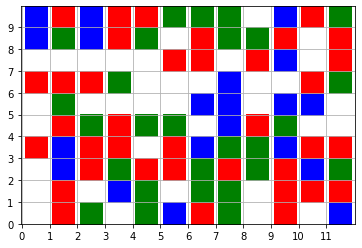

In [299]:
city = Schelling(12,10,0.3,0.5,100,3)
city.populate()
#print(city.agents)
city.plot_city()


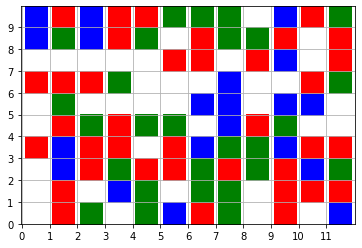

In [300]:
city.update((6,2))
city.plot_city()

In [301]:
city.similarity_index()

ZeroDivisionError: division by zero

#### B. Write a method called **populate** which can be used to create an initial distribution of people in the grid.

To do this, we will try to design the method as follows:

1. the method creates new attributes: ```self.empty_houses``` as an empty list, ```self.agents``` as an empty dictionary. 
2. the method creates a new attribute ```self.all_houses``` as a list of all houses (hint: use ```itertools```, see suggestions below)
3. the method randomizes the allocation of houses (hint: use ```random.shuffle()``` for this task, see below)
4. the method creates a new attribute ```self.n_empty``` which is derived as the number of the empty houses (this is calculated by using the ```self.empty_ratio``` and the number of houses in the city )
5. the method sets the empty_houses to be the last ```self.n_empty``` houses
6. the remaining houses are assigned to ```self.remaining_houses```
7. we use ```self.remainging_houses``` to assign races to each house, creating a variable called ```houses_by_races```
8. we fill the dictionary ```self.agents``` with the ```house_by_race``` in which each agent lives (hint: use ```zip``` and the ```update``` method for dictionaries.


#### C. Write a method called **plot_city** which plots the city with all the empty and occupied houses with the right colours. 

The method ```plot_city``` sets up the parameters for the graph, and spits out fig and ax objects (matplotlib). Notice that we need to set xticks and yticks of the grid, and the grid itself (check [matplotlib](https://matplotlib.org/) documentation for details). The grid should have the dimension indicated by width and height attributes. Consider a scatter plot with square markers (also important to determine the right size for them)

Use this method to plot an instance of the class. 

#### D. Write a method called **is_unsatisfied** which evaluates if a specific cell in the grid is satisfied with the location or not. 

This method should check if an agent in a cell is unsatisfied with the neighbours it has or not. This task can be done in several ways, but here is a suggestion:

1. create a method which takes the coordinates of the house as arguments (on top of the object instance). 
2. the method builds a set of neighbours using this picture as reference: 

<img src="CA-Moore.png" alt="alt text" width="200"/>

3. the method then checks if each of these neighbours is of the same race or not, and counts how many neighbours are of the same race, and how many aren't. 
4. The method returns ```True``` if the ratio of same race neighbours to total is less than the similarity threshold, ```False``` otherwise. 

#### E. Write a method called **update** which checks each cell in the grid, verifies if it is satisfied or not, and if not it moves it to a random empty cell. 

This method checks if each agent is unsatisfied, and in that case, it fills a randomly chosen empty house with it. 
Important: remember to remove the location of the emptied house from ```self.agents``` and add it to ```self.empty_houses```!

#### F. Create a method that calculates an index of similarity 

To calculate this index:
1. calculate for each agent the ratio between the neighbours of the same race to the neighbours from a different race. 
2. sum up, and divide by the number of agents. 

#### G. Use this class to generate some experiments, by playing with the parameters (size of the city, similarity threshold, number of races, etc.) 

Make several experiments to analyse how the results change when we change one parameter at the time. 

## Things we may want to learn

```itertools.product(x, y)``` is a great way to create all the possible combinations of elements of x and y

In [13]:
import itertools

a = [1, 2, 3]
b = [4, 5, 6]

c = list(itertools.product(a, b))
print(c)

[(1, 4), (1, 5), (1, 6), (2, 4), (2, 5), (2, 6), (3, 4), (3, 5), (3, 6)]


```random.shuffle()``` does a random reshuffling of a list

In [2]:
import random

d = [1, 2, 3, 4, 5, 6, 7]
random.shuffle(d)

print(d)

[4, 2, 7, 6, 5, 1, 3]


In [ ]:
self.width = [1, 2, 3]
self.height = [4, 5, 6]

self.all_houses = 
